## Signal-to-noise calculations

**Author:** Deb Lokhorst (NRC Herzberg Astronomy & Astrophysics Research Centre)<br>
**Date:** 2024-02-16

### Some background

The SNR is calculated following the equation (see, e.g., pg 407 of "Spectroscopic Instrumentation" by Eversberg and Vollmann): 

$SNR = \frac{I t}{\sqrt{I t + B t + D t + R^2}}$, 

where I is the signal over some number of pixels, B is the sky background over some number of pixels, D is the dark current over some number of pixels and R is the readout noise of the detector.  The exposure time, t, is usually given in seconds.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as const
from astropy import units as u
from astropy.io import fits
import math

In [2]:
class DragonflySystem(object):

    """This class represented the noise calculations 
    for the Dragonfly Array."""

    def __init__(self, number_of_lenses = 48.,oldcam=False):
        self.number_of_lenses = number_of_lenses
        self.area_lens = self.calculate_lens_area()
        self.tau_l = 0.85  # transmittance of the Dragonfly lens
        self.tau_f = 1.    # transmittance of the Halpha filter -- assumed for now
        if oldcam:
            self.QE = 0.48 * u.electron / u.photon
            self.ro_noise = 10.  # read noise (electrons)
            self.dark_curr = 0.02 *u.photon/u.second    # dark current (electrons / s / pix)
            self.pix_size = 2.8 # arcsec / pix
        else:
            self.QE = 0.75 * u.electron / u.photon
            self.ro_noise = 4.5  # read noise (electrons)
            self.dark_curr = 0.025 *u.electron/u.second    # dark current (electrons / s / pix)
            self.pix_size = 2.45 # arcsec / pix

        self.ang_pix_size = (self.pix_size * (1./206265.))**2 * u.rad**2
        self.ro_squared = self.ro_noise**2 * u.electron

    def calculate_lens_area(self):
        return np.pi*(14.3/2)**2 * self.number_of_lenses * u.cm**2
    
    def report(self):
        print('Number of lenses (lens area): %s (%s)'%\
              (self.number_of_lenses,self.area_lens))
        print('Quantum Efficiency: %s'%self.QE)
        print('Readout Noise (RO squared): %s (%s)'%\
              (self.ro_noise,self.ro_squared))
        print('Dark Current: %s'%self.dark_curr)
        print('Pixel Size: %s'%self.pix_size)

    
    def calculate_signal_to_noise(self,SB_ph,B,time,numpixel=1,explength=30.*(60.*u.second)):
        print('Calculating SNR for SB of %s'%SB_ph)

        numexp=1
        if isinstance(time.value, (np.ndarray)):
            numexp = np.array([math.ceil(thistime/explength) for thistime in time])
        else:
            numexp = math.ceil(time/explength) # round up the number of exposures
        print('Total exposure time of %s carried out in %s exposure(s).'%(time,numexp))
            
        
        S = SB_ph * self.QE * self.tau_l * self.tau_f 
        S *= self.area_lens * self.ang_pix_size
        signal = S*time*numpixel

        B_tot = B * self.QE * self.tau_l * self.tau_f 
        B_tot *= self.area_lens.to(u.m**2) * self.ang_pix_size.to(u.arcsec**2)

        print('total S: %s'%signal)
        print('total B (sky): %s'%(B_tot*time*numpixel))
        print('\t square root: %s'%(np.sqrt(B_tot*time*numpixel)))
        print('total D (dark): %s'%(self.dark_curr*time*numpixel*self.number_of_lenses))
        print('\t square root: %s'%(np.sqrt(self.dark_curr*time*numpixel*self.number_of_lenses)))
        print('total R (readout): %s'%(self.ro_noise*numpixel*self.number_of_lenses*numexp))
        #sigma = np.sqrt(signal + B_tot*time*numpixel + D*time*numpixel + R_squared*numpixel)

        sigma = np.sqrt(signal + B_tot*time*numpixel + self.dark_curr*time*numpixel*self.number_of_lenses + 
                        self.ro_noise*numpixel*self.number_of_lenses*numexp*u.electron)

        SNR = signal/sigma

        return SNR

In [4]:
# plt.style.use('seaborn-dark-palette')
plt.style.use('ggplot')
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}
import matplotlib
matplotlib.rc('font', **font)

TINY_SIZE = 14
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=TINY_SIZE)     # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


#### from SkyBackground_FilterWidthComparison  (In FilterTilterDesign and HalphaScripts):

We need to include the sky background as a source of noise in our calculations. This value was calculated from the Gemini sky background spectrum.

In [5]:
# B_10nm_G_1  = 4.91488*u.photon/u.second/u.arcsec**2/u.m**2  # already times the filter width
# B_3nm_G_1  = 1.52495*u.photon/u.second/u.arcsec**2/u.m**2  # already times the filter width
B_08nm_G_1 = 0.383995*u.photon/u.second/u.arcsec**2/u.m**2  # already times the filter width

Declare the Dragonfly System and calculate SNR for a specific exposure time

In [6]:
dragonfly = DragonflySystem()

# Using an exposure time of 60 hours:
time = 60.*60.*60. * u.second

# This is a typical SB of features in the cosmic web
SB_ph_three = 10**3. * u.photon / (u.cm**2 * u.rad**2 * u.second)

# Assuming that we will be binning over some pixels to increase the SNR
pix_size = 2.8 
numpixel = 100.0 * 100.0/(pix_size**2)   # 100-arcsec-a-side pixels

# Run the calculation
SNR = dragonfly.calculate_signal_to_noise(SB_ph_three,B_08nm_G_1,time,numpixel=numpixel) #,explength=time)
print (SNR)


Calculating SNR for SB of 1000.0 ph / (s cm2 rad2)
Total exposure time of 216000.0 s carried out in 120 exposure(s).
total S: 191030.25601612046 electron
total B (sky): 312088663.6112715 electron
	 square root: 17666.03134864397 electron(1/2)
total D (dark): 330612244.89795923 electron
	 square root: 18182.745801939796 electron(1/2)
total R (readout): 33061224.48979592
7.347572082218211 electron(1/2)


Calculating SNR for SB of 1000.0 ph / (s cm2 rad2)
Total exposure time of [1.00000e+00 6.10000e+01 1.21000e+02 ... 1.43821e+05 1.43881e+05
 1.43941e+05] s carried out in [ 1  1  1 ... 80 80 80] exposure(s).
total S: [8.84399333e-01 5.39483593e+01 1.07012319e+02 ... 1.27195197e+05
 1.27248260e+05 1.27301324e+05] electron
total B (sky): [1.44485492e+03 8.81361504e+04 1.74827446e+05 ... 2.07800480e+08
 2.07887171e+08 2.07973863e+08] electron
	 square root: [   38.01124734   296.8773322    418.12372071 ... 14415.28633232
 14418.2929412  14421.29892325] electron(1/2)
total D (dark): [1.53061224e+03 9.33673469e+04 1.85204082e+05 ... 2.20134184e+08
 2.20226020e+08 2.20317857e+08] electron
	 square root: [   39.12303982   305.56070909   430.35343804 ... 14836.91961539
 14840.01416469 14843.10806883] electron(1/2)
total R (readout): [  275510.20408163   275510.20408163   275510.20408163 ...
 22040816.32653061 22040816.32653061 22040816.32653061]


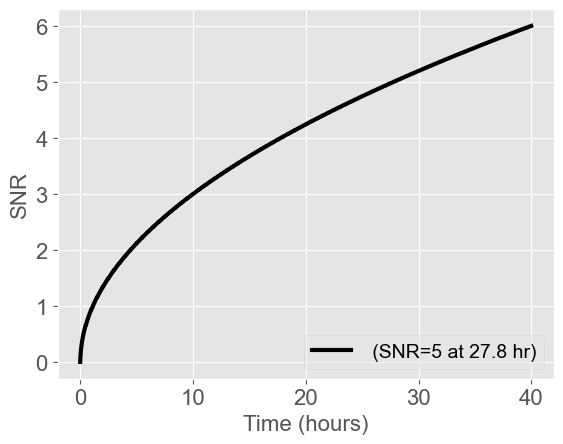

In [10]:
def plotSNR(SB_ph,B,time,numpixel=1,refSNR=5.0,linestyle='-',label='',colour='black'):
    # SNR = calcSNR(SB_ph,B,time,explength=10.*(60.*u.second))
    SNR = dragonfly.calculate_signal_to_noise(SB_ph,B,time,numpixel=numpixel) #,explength=time)
    ind = (np.abs(SNR.value-refSNR)).argmin()
    plt.plot(time/3600.,SNR,label=label+' (SNR=5 at %.1f hr)'%(time[ind]/3600.).value,\
             linewidth=3,linestyle=linestyle,color=colour)
    return SNR,ind,time[ind]/3600.

# Array of times out to 40 hours
time = np.arange(1,60.*60.*40.,60.)* u.second

# Again binning the number of pixels to increase the SNR
pix_size = 2.8 
numpixel = 100.0 * 100.0/(pix_size**2)   # 100-arcsec-a-side pixels

# Calculating SNR for the array of time values, using same signal and sky background as above
SNR,ind,total = plotSNR(SB_ph_three,B_08nm_G_1,time,numpixel=numpixel)

plt.xlabel('Time (hours)')
plt.ylabel('SNR')
plt.legend(loc=4,fancybox=True, framealpha=0.5)


#### Calculate the flux from a point source with specific magnitude - if you want to use different sources to calculate the SNR


Conversion between photon/pixel and mag arcsec
$^{-2}$ (from Abraham et al. 2014):

>The surface brightness in equation (4), S, can be cast into units of
magnitude per arcsecsecond squared (mag arcsec$^{-2}$) by noting that
$S = F \times 10^{-0.4\mu} $
, where F is the flux zero point for the
filter and $\mu$ is the mean surface brightness in magnitude units in the bandpass.

>In the AB system, the zeroth magnitude calibrator is defined in frequency space as 3631 Jy in all bands, so after conversion back to wavelength space, 
$F = (3631 Jy/arcsec^{2}) \times c / \lambda^2$
,where $\lambda$ is the effective wavelength of the filter.

> https://irsa.ipac.caltech.edu/data/SPITZER/docs/dataanalysistools/tools/pet/magtojy/: <br>
> Johnson V = 21.5, Zeropoint: 3781, Effective wavelength: 0.55 microns: 0.0095mJy

If assume that the point source only goes on one pixel, then a lot of this simplifies.<br>
S = tot<br>
S = (tot/numpixels) * numpixels

If source is spread out then will be harder to detect (more electronic noise). Assume the m_v is the literal point source limit, so assume all on one pixel.

In [8]:
def getflux_ph(flux_cgs,photon_wavelength=656.3e-9*u.m):
    return flux_cgs * photon_wavelength/(const.h.to('erg s') * const.c.to('m/s')) * u.photon

### from https://irsa.ipac.caltech.edu/data/SPITZER/docs/dataanalysistools/tools/pet/magtojy/ for source of V = 17.5 mag

### 17.5 mag in V band to use as estimate for needed exp lengths
flux_cgs = 3.75e-16 * u.erg / u.cm**2 / u.s / u.angstrom # erg/s/cm^2/Ang # V=17.5 mag
photon_wavelength = 550e-9*u.m # for V band
bw_nbfilters = 0.8 #nm

flux_ph = getflux_ph(flux_cgs,photon_wavelength=photon_wavelength)
flux_ph_tot = flux_ph*bw_nbfilters*10 * u.angstrom
